# Splitting, Preprocessing and Model Development
This notebook is used for:
1. [Introduce Lagged Features](#1.-Introduce-Lagged-Features)
2. [Dataset Splitting](#2.-Dataset-Splitting-&-Preprocessing)
3. [General Model Development Functions](#3.-General-Model-Development-Functions)
4. [Model Training](#4.-Model-Training)

### Declaring Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm, Normalize
import sklearn
import time
import datetime
import joblib
import warnings
from sklearn.model_selection import ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

### Color Palette & Typeface Sizing

In [2]:
YELLOW = '#F2DC5D'
GREEN = '#9BC53D'
DARK_GREEN = '#597222'
RED = '#C3423F'
LIGHT_BLUE = '#2596BE'
GRAY = '#666666'
WHITE = '#FFFFFF'

AXIS_SIZE = 12
TITLE_SIZE = 16
DESCRIPTION_SIZE = 9
FIGURE_SIZE = (10*2/3,6*2/3)
EXPORT_DPI = 400

RANDOM_STATE = 14

### Import Dataframe

In [3]:
df = pd.read_csv('../data/final.csv', dtype={'citizen': 'string', 'sex': 'string', 'age': 'string', 'decision': 'string', 'geo': 'string', 'TIME_PERIOD': 'string', 'GENCONV': "Int64", 'HUMSTAT': "Int64", 'SUB_PROT': "Int64", 'REJECTED': "Int64", 'TOTAL_POS': "Int64", 'TOTAL_APPS': "Int64", "POS_RATE": "Float64"}, keep_default_na=False, na_values=['nan'])

##remove partial 2023-Q3 Data
df = df[df["TIME_PERIOD"] != "2023-Q3"]

df

,citizen,sex,age,geo,TIME_PERIOD,GENCONV,HUMSTAT,SUB_PROT,REJECTED,TOTAL_POS,TOTAL_APPS
0,AD,F,UNK,AT,2008-Q1,0,0,0,0,0,0
1,AD,F,UNK,AT,2008-Q2,0,0,0,0,0,0
2,AD,F,UNK,AT,2008-Q3,0,0,0,0,0,0
3,AD,F,UNK,AT,2008-Q4,0,0,0,0,0,0
4,AD,F,UNK,AT,2009-Q1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
7221109,ZW,UNK,Y_LT14,UK,2019-Q3,0,0,0,0,0,0
7221110,ZW,UNK,Y_LT14,UK,2019-Q4,0,0,0,0,0,0
7221111,ZW,UNK,Y_LT14,UK,2020-Q1,0,0,0,0,0,0
7221112,ZW,UNK,Y_LT14,UK,2020-Q2,0,0,0,0,0,0


## 1. Introduce Lagged Features

In [4]:
#****************************************************re-sort dataframe****************************************************

sort_order = ['citizen', 'sex', 'age', 'geo', 'TIME_PERIOD']
df = df.sort_values(by =sort_order) 

#*********************************************create sequential list of quarters****************************************************

quarters = []
for i in range(2008, 2024):
    quarters.append(str(i) + "-Q1")
    quarters.append(str(i) + "-Q2")
    quarters.append(str(i) + "-Q3")
    quarters.append(str(i) + "-Q4")

#****************************************************lagged features****************************************************

QUARTERS_OF_LAG = (4 * 1)

def add_lagged_features(df, features, maintained_columns, QUARTERS_OF_LAG):
    quarters = np.unique(df["TIME_PERIOD"])
    def lagged_features(target_var, lag_count, unit):
        lagged = pd.DataFrame()
        columns = []
        for i in range(1, lag_count + 1):
            lagged = pd.concat([lagged, target_var.shift(i)], axis=1)
            name = target_var.name
            if (i == 1):
                columns.append(name + " - lag " + str(i) + " " + str(unit))
            else:
                columns.append(name + " - lag " + str(i) + " " + str(unit) + "s")
        lagged.columns = columns
        return lagged.astype('Int64')

    #introduce lag for each feature
    df_lagged = df
    for f in features:
        df_lagged = pd.concat([df_lagged, lagged_features(df[f], QUARTERS_OF_LAG, "quarter")], axis=1)

    #remove all features with less than the lag amount of historical data
    #df_lagged = df_lagged[df_lagged.eq()]
    for i in range(0, QUARTERS_OF_LAG):
        shift_eq = df_lagged.eq(df_lagged.shift())
        keep = shift_eq[maintained_columns[0]]
        for j in range(1, len(maintained_columns)):
            keep = keep & shift_eq[maintained_columns[j]]
        df_lagged = df_lagged[keep]
        #print("lagged i" + str(i) + " of " + str(QUARTERS_OF_LAG))
    
    return df_lagged

df_lagged = add_lagged_features(df, ["TOTAL_POS", "TOTAL_APPS"], ['citizen', 'age', 'sex', 'geo'], QUARTERS_OF_LAG)

df_lagged

,citizen,sex,age,geo,TIME_PERIOD,GENCONV,HUMSTAT,SUB_PROT,REJECTED,TOTAL_POS,TOTAL_APPS,TOTAL_POS - lag 1 quarter,TOTAL_POS - lag 2 quarters,TOTAL_POS - lag 3 quarters,TOTAL_POS - lag 4 quarters,TOTAL_APPS - lag 1 quarter,TOTAL_APPS - lag 2 quarters,TOTAL_APPS - lag 3 quarters,TOTAL_APPS - lag 4 quarters
4,AD,F,UNK,AT,2009-Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,AD,F,UNK,AT,2009-Q2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,AD,F,UNK,AT,2009-Q3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,AD,F,UNK,AT,2009-Q4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,AD,F,UNK,AT,2010-Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7221109,ZW,UNK,Y_LT14,UK,2019-Q3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7221110,ZW,UNK,Y_LT14,UK,2019-Q4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7221111,ZW,UNK,Y_LT14,UK,2020-Q1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7221112,ZW,UNK,Y_LT14,UK,2020-Q2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Lagged Feature Testing

In [5]:
#***********************************************testing equivalence function****************************************************
def equivalent_dfs(df1, df2):
    return (df1.reset_index(drop=True) == df2.reset_index(drop=True)).all().all()

#****************************************************lagging testing****************************************************
print("[*] testing lagging function")
#simple tests
tdf0_data = [['AR', 1, 1], ['AR', 2, 2], ['AR', 3, 3], ['AR', 4, 4], ['AR', 5, 5]]
tdf0 = pd.DataFrame(data=tdf0_data, columns=['citizen', 'TIME_PERIOD', 'val'])
tdf1_data = [['AR', 2, 2, 1], ['AR', 3, 3, 2], ['AR', 4, 4, 3], ['AR', 5, 5, 4]]
tdf1 = pd.DataFrame(data=tdf1_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter'])
tdf2_data = [['AR', 3, 3, 2, 1], ['AR', 4, 4, 3, 2], ['AR', 5, 5, 4, 3]]
tdf2 = pd.DataFrame(data=tdf2_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter', 'val - lag 2 quarters'])
tdf3_data = [['AR', 4, 4, 3, 2, 1], ['AR', 5, 5, 4, 3, 2]]
tdf3 = pd.DataFrame(data=tdf3_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter', 'val - lag 2 quarters', 'val - lag 3 quarters'])

assert equivalent_dfs(add_lagged_features(tdf0, ["val"], ['citizen'], 1), 
                      tdf1), "basic lag test failed, shift=1"
assert equivalent_dfs(add_lagged_features(tdf0, ["val"], ['citizen'], 2), 
                      tdf2), "basic lag test failed, shift=2"
assert equivalent_dfs(add_lagged_features(tdf0, ["val"], ['citizen'], 3), 
                      tdf3), "basic lag test failed, shift=3"
print("\t[+] basic lag tests passed")

#more advanced tests
tdf4_data = [['AU', 1, 1], ['AU', 2, 2], ['AU', 3, 3], ['AU', 4, 4], ['AU', 5, 5],
             ['NZ', 1, 11], ['NZ', 2, 12], ['NZ', 3, 13], ['NZ', 4, 14], ['NZ', 5, 15]]
tdf4 = pd.DataFrame(data=tdf4_data, columns=['citizen', 'TIME_PERIOD', 'val'])
tdf5_data = [['AU', 2, 2, 1], ['AU', 3, 3, 2], ['AU', 4, 4, 3], ['AU', 5, 5, 4],
             ['NZ', 2, 12, 11], ['NZ', 3, 13, 12], ['NZ', 4, 14, 13], ['NZ', 5, 15, 14]]
tdf5 = pd.DataFrame(data=tdf5_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter'])
tdf6_data = [['AU', 3, 3, 2, 1], ['AU', 4, 4, 3, 2], ['AU', 5, 5, 4, 3],
             ['NZ', 3, 13, 12, 11], ['NZ', 4, 14, 13, 12], ['NZ', 5, 15, 14, 13]]
tdf6 = pd.DataFrame(data=tdf6_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter', 'val - lag 2 quarters'])


assert equivalent_dfs(add_lagged_features(tdf4, ["val"], ['citizen'], 1), 
                      tdf5), "lag with shared times test failed, shift=1"
assert equivalent_dfs(add_lagged_features(tdf4, ["val"], ['citizen'], 2), 
                      tdf6), "lag with shared times test failed, shift=2"
print("\t[+] tests with shared times passed")

#very complicated tests
tdf7_data = [['AU', 1, 1], ['AU', 2, 2], ['AU', 3, 3], ['AU', 4, 4], ['AU', 5, 5],
             ['NZ', 2, 12], ['NZ', 3, 13], ['NZ', 4, 14], ['NZ', 5, 15]]
tdf7 = pd.DataFrame(data=tdf7_data, columns=['citizen', 'TIME_PERIOD', 'val'])
tdf8_data = [['AU', 2, 2, 1], ['AU', 3, 3, 2], ['AU', 4, 4, 3], ['AU', 5, 5, 4],
             ['NZ', 3, 13, 12], ['NZ', 4, 14, 13], ['NZ', 5, 15, 14]]
tdf8 = pd.DataFrame(data=tdf8_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter'])
tdf9_data = [['AU', 3, 3, 2, 1], ['AU', 4, 4, 3, 2], ['AU', 5, 5, 4, 3],
             ['NZ', 4, 14, 13, 12], ['NZ', 5, 15, 14, 13]]
tdf9 = pd.DataFrame(data=tdf9_data, columns=['citizen', 'TIME_PERIOD', 'val', 'val - lag 1 quarter', 'val - lag 2 quarters'])
tdf10_data = [['AU', 1, 1], ['AU', 2, 2], ['AU', 3, 3], ['AU', 4, 4], ['AU', 5, 5],
              ['NZ', 2, 12], ['NZ', 3, 13], ['NZ', 4, 14], ['NZ', 5, 15],
              ['FJ', 3, 23], ['FJ', 4, 24], ['FJ', 5, 25], ['FJ', 6, 26], ['FJ', 7, 27], ['FJ', 8, 28],
              ['WS', 4, 34], ['WS', 5, 35]]
tdf10 = pd.DataFrame(data=tdf10_data, columns=['citizen', 'TIME_PERIOD', 'new_val'])
tdf11_data = [['AU', 2, 2, 1], ['AU', 3, 3, 2], ['AU', 4, 4, 3], ['AU', 5, 5, 4],
              ['NZ', 3, 13, 12], ['NZ', 4, 14, 13], ['NZ', 5, 15, 14],
              ['FJ', 4, 24, 23], ['FJ', 5, 25, 24], ['FJ', 6, 26, 25], ['FJ', 7, 27, 26], ['FJ', 8, 28, 27],
              ['WS', 5, 35, 34]]
tdf11 = pd.DataFrame(data=tdf11_data, columns=['citizen', 'TIME_PERIOD', 'new_val', 'new_val - lag 1 quarter'])
tdf12_data = [['AU', 5, 5, 4, 3, 2, 1],
              ['FJ', 7, 27, 26, 25, 24, 23], ['FJ', 8, 28, 27, 26, 25, 24]]
tdf12 = pd.DataFrame(data=tdf12_data, columns=['citizen', 'TIME_PERIOD', 'new_val', 'new_val - lag 1 quarter', 'new_val - lag 2 quarters', 'new_val - lag 3 quarters', 'new_val - lag 4 quarters'])

assert equivalent_dfs(add_lagged_features(tdf7, ["val"], ['citizen'], 1), 
                      tdf8), "lag with 2 different start times test failed, shift=1"
assert equivalent_dfs(add_lagged_features(tdf7, ["val"], ['citizen'], 2), 
                      tdf9), "lag with 2 different start times test failed, shift=2"
assert equivalent_dfs(add_lagged_features(tdf10, ["new_val"], ['citizen'], 1), 
                      tdf11), "lag with many different start times test failed, shift=1"
assert equivalent_dfs(add_lagged_features(tdf10, ["new_val"], ['citizen'], 4), 
                      tdf12), "lag with many different start times test failed, shift=4"
print("\t[+] tests with multiple start and end dates passed")

print("\t[+] \x1b[42mPASSED ALL\x1b[0m lagging tests")

[*] testing lagging function
	[+] basic lag tests passed
	[+] tests with shared times passed
	[+] tests with multiple start and end dates passed
	[+] PASSED ALL lagging tests


## 2. Dataset Splitting & Preprocessing

### Splitting

In [6]:
TARGET_VAR = "TOTAL_POS"

y = df_lagged[TARGET_VAR]
X = df_lagged.drop(['GENCONV', 'HUMSTAT', 'SUB_PROT', 'REJECTED', 'TOTAL_POS'], axis=1)
#PLAN:
#of 62 quarters...
#QUARTERS_OF_LAG are lost bc they wont have the needed lagged features
    
new_quarters = [q for q in quarters if q >= quarters[QUARTERS_OF_LAG]]
quarter_count = len(new_quarters) - 1

TRAIN_PORTION = 0.6
VAL_PORTION = 0.2
TEST_PORTION = 0.2

#take out last portion of quarters for testing
#div_0 = new_quarters[0]
#div_1 = new_quarters[int(quarter_count * train_split)]
div_2 = new_quarters[int(quarter_count * (1 - TEST_PORTION))]
div_3 = new_quarters[quarter_count]

#seperate out test section
X_test = X[(div_2 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_3)]
y_test = y[(div_2 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_3)]

#### Splitting Visualization

/Users/alexanderportland/anaconda3/envs/data1030/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:807: UserWarning: The label '_white' of <BarContainer object of 4 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


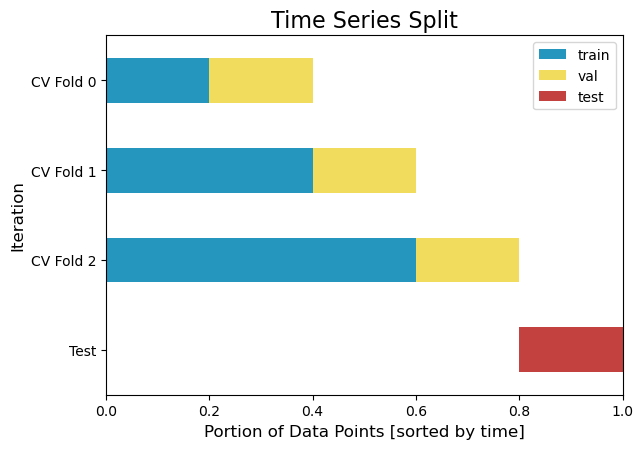

In [7]:
data = [[0.2, 0.2, 0.6, 0], [0.4, 0.2, 0.4, 0], [0.6, 0.2, 0.2, 0], [0, 0, 0.8, 0.2]]
split_df = pd.DataFrame(data, columns=['train', 'val', '_white', 'test']).iloc[::-1]
split_df.index = ['Test', 'CV Fold 2', 'CV Fold 1', 'CV Fold 0']


fig_title = "data-split.png"
fig_description=""""""

split_df.plot(kind='barh', stacked=True, color=[LIGHT_BLUE, YELLOW, WHITE, RED], xlim=(0, 1), figsize=(10*2/3,7*2/3))

plt.xlabel('Portion of Data Points [sorted by time]', fontsize=AXIS_SIZE)
plt.title('Time Series Split', fontsize=TITLE_SIZE)
plt.ylabel('Iteration', fontsize=AXIS_SIZE)

plt.figtext(0.14, -0.12, fig_description, wrap=False, horizontalalignment='left', verticalalignment='top', fontsize=DESCRIPTION_SIZE)
plt.savefig("../figures/" + fig_title, bbox_inches="tight", pad_inches=0.4, dpi=EXPORT_DPI, transparent=False)
plt.show()

### Preprocessing

In [8]:
ordinal_ftrs = ['age', 'TIME_PERIOD']
ordinal_cats = [['UNK','Y_LT14','Y14-17','Y18-34','Y35-64','Y_GE65'], quarters]
                                                                     #^^i'm using quarters not new_quarters here so that
                                                                     #  the model can still tell where in history this q is
onehot_ftrs = ['citizen', 'geo', 'sex']
#onehot_ftrs = ['geo', 'sex']
minmax_ftrs = []
std_ftrs = [a for a in X.columns.to_list() if 'TOTAL' in a]
poly_ftrs = ['TOTAL_APPS', 'TOTAL_POS - lag 1 quarter', "TOTAL_APPS - lag 1 quarter"]

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs),
        ('poly', PolynomialFeatures(degree=(2,2), interaction_only=False), poly_ftrs)
    ])

## 3. General Model Development Functions
### Evaluation Functions

In [9]:
def RMSE(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).sum() / len(y_pred))

def ALL_ZERO_BASELINE(y_true):
    return np.sqrt(((y_true) ** 2).sum() / len(y_true))

def ALL_MEAN_BASELINE(y_train, y_true):
    mean = y_train.mean()
    return np.sqrt(((mean - y_true) ** 2).sum() / len(y_true))

### Helper Functions

In [10]:
def TIMESTAMP_STR():
    dt = datetime.datetime.now()
    txt = "{hour}:{minute:02.0f} on {day}-{month}-{year}"
    return txt.format(hour=dt.hour, minute=dt.minute, day=dt.day, month=dt.month, year=dt.year)

def DF_ALL_PREDICTED(model):
    df_new = df
    df_new["TOTAL_APPS_PRED"] = model.predict(X)

UPDATE = True
def Status_Update(t, message):
    my_time = time.time()
    if UPDATE:
        print(str(message) + " \t-- in " + str(time.time() - t) + "s")
    return time.time()

### General Model-Training Function

In [11]:
def MLPipe_TimeSeries_RMSE(X, y, preprocessor, ML_algo, param_grid):
    ALGO_NAME = str(ML_algo)[str(ML_algo).rindex('.')+1:-2]
    MODEL_NAME = "{algo}({time})".format(algo=ALGO_NAME, time=TIMESTAMP_STR())
    NUM_FOLDS = np.round(TRAIN_PORTION / VAL_PORTION).astype(int)
    RANDOM_STATE = 14
    print("[!] looking at model: " + str(MODEL_NAME))
    
    print("\t[*] doing initial dataset splitting")
    
    #opt check 2
    X_trains = []
    y_trains = []
    X_vals = []
    y_vals = []
    for i in range(1, NUM_FOLDS + 1):
        train_portion = np.round(i * VAL_PORTION, 2)
        div_0 = new_quarters[0]
        div_1 = new_quarters[int(quarter_count * train_portion)]
        div_2 = new_quarters[int(quarter_count * (train_portion + VAL_PORTION))]

        X_trains.append(X[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        y_trains.append(y[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        X_vals.append(X[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        y_vals.append(y[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        print("\t\t[+] fold " + str(i))
    
    param_scores = []
    param_models = []
    for p in param_grid:
        T_PARAM_START = time.time()
        fold_scores = []
        print("\t[*] looking at hyperparameters " + str(p))
        for i in range(NUM_FOLDS, NUM_FOLDS + 1):
            T_FOLD_START = time.time()
            #ADD OPTIMIZATION HERE:
                #[2] NO NEED TO CONSTANTLY REDIVIDE THE DATA, SAME THREE FOLDS WILL BE USED EACH TIME REGARDLES OF HYPERPARAMAETERS
                #[1] NO NEED TO CHECK FUTURE FOLDS IF EVEN A SCORE OF ZERO WOULDN'T BRING IT BELOW A BETTER FOUND PARAMETER ARRANGEMENT
            train_portion = np.round(i * VAL_PORTION, 2)
            
            #opt check 1
            if (i > 0 & len(param_scores) > 0):
                best_param_score = param_scores[np.argmin(param_scores)]
                if ((best_param_score * 3) < np.sum(fold_scores)):
                    print("[!] best average score I could get with " + str(np.sum(fold_scores)) + " score already is worse than a previous params score of " + str(best_param_score) + ", so giving up")

            mini_t = time.time()
            
            X_train = X_trains[i - 1]
            y_train = y_trains[i - 1]
            X_val = X_vals[i - 1]
            y_val = y_vals[i - 1]
            
            #PORTION_OF_POINTS = 0.001
            #X_train = X_train.sample(np.floor((len(X_train) * PORTION_OF_POINTS)).astype(int), random_state = RANDOM_STATE)
            #y_train = y_train.loc[X_train.index]
            #X_val = X_val.sample(np.floor((len(X_val) * PORTION_OF_POINTS)).astype(int), random_state = RANDOM_STATE)
            #y_val = y_val.loc[X_val.index]
            
            mini_t = Status_Update(mini_t, "split data")

            #make pipeline
            if ((ALGO_NAME == "SVR") | (ALGO_NAME == "LinearRegression") | (ALGO_NAME == "RandomForestRegressor")):
                algo = ML_algo(**p)
            else:
                algo = ML_algo(**p, random_state = RANDOM_STATE)
            
            #print(algo)
            pipe = Pipeline(steps=[
                        ('preprocess', preprocessor),
                        ('model', algo)
                    ], verbose=True)
            
            mini_t = Status_Update(mini_t, "made pipeline")

            pipe.fit(X_train, y_train)
            mini_t = Status_Update(mini_t, "fit pipeline")
            
            y_pred = pipe.predict(X_val)
            score = RMSE(y_pred, y_val)
            
            fold_scores.append(score)
            T_FOLD_END = time.time()
            T_FOLD_ELAPSED = T_FOLD_END - T_FOLD_START
            mini_t = Status_Update(mini_t, "eval pipeline")
            print("\t\t[*] fold " + str(i) + " complete (test score of " + str(score) + ") -- in " + str(np.round(T_FOLD_ELAPSED, 3)) + "s")
        score = np.mean(fold_scores)
        param_scores.append(score)
        param_models.append(pipe)
        
        T_PARAM_END = time.time()
        T_PARAM_ELAPSED = T_PARAM_END - T_PARAM_START
        print("\t\t[+] final score for params of " + str(score) + " -- in " + str(np.round(T_PARAM_ELAPSED, 3)) + "s")
        
        if (np.argmin(param_scores) == (len(param_scores) - 1)):
            best_model = param_models[np.argmin(param_scores)]
            print("\t\t[!] new best param configuration, so saving model to path")
            path = "../results/" + MODEL_NAME + ".pkl"
            joblib.dump(best_model, path, compress = 1)
            print("\t\t\t[+] saved model to " + str(path))
        
        
    i_best = np.argmin(param_scores)
    best_score = param_scores[i_best]
    best_params = param_grid[i_best]
    best_model = param_models[i_best]
    print("\t[+] best param configuration of " + str(best_params) + " found with score " + str(best_score))
    path = "../results/" + MODEL_NAME + ".pkl"
    joblib.dump(best_model, path, compress = 1)
    print("\t[+] saved model to " + str(path))

### General XGBoost Training Function

In [12]:
def TRAIN_XGBOOST(X, y, preprocessor, ML_algo, param_grid):
    ALGO_NAME = str(ML_algo)[str(ML_algo).rindex('.')+1:-2]
    MODEL_NAME = "{algo}({time})".format(algo=ALGO_NAME, time=TIMESTAMP_STR())
    NUM_FOLDS = np.round(TRAIN_PORTION / VAL_PORTION).astype(int)
    RANDOM_STATE = 14
    print("[!] looking at XGBoost model: " + str(MODEL_NAME))
    
    print("\t[*] doing initial dataset splitting")
    
    #opt check 2
    X_trains = []
    y_trains = []
    X_vals = []
    y_vals = []
    for i in range(1, NUM_FOLDS + 1):
        train_portion = np.round(i * VAL_PORTION, 2)
        div_0 = new_quarters[0]
        div_1 = new_quarters[int(quarter_count * train_portion)]
        div_2 = new_quarters[int(quarter_count * (train_portion + VAL_PORTION))]

        X_trains.append(X[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        y_trains.append(y[(div_0 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_1)])
        X_vals.append(X[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        y_vals.append(y[(div_1 <= X["TIME_PERIOD"]) & (X["TIME_PERIOD"] < div_2)])
        print("\t\t[+] fold " + str(i))
    
    param_scores = []
    param_models = []
    for p in param_grid:
        T_PARAM_START = time.time()
        fold_scores = []
        print("\t[*] looking at hyperparameters " + str(p))
        for i in range(1, NUM_FOLDS + 1):
            T_FOLD_START = time.time()
            #ADD OPTIMIZATION HERE:
                #[2] NO NEED TO CONSTANTLY REDIVIDE THE DATA, SAME THREE FOLDS WILL BE USED EACH TIME REGARDLES OF HYPERPARAMAETERS
                #[1] NO NEED TO CHECK FUTURE FOLDS IF EVEN A SCORE OF ZERO WOULDN'T BRING IT BELOW A BETTER FOUND PARAMETER ARRANGEMENT
            train_portion = np.round(i * VAL_PORTION, 2)
            
            #opt check 1
            if (i > 0 & len(param_scores) > 0):
                best_param_score = param_scores[np.argmin(param_scores)]
                if ((best_param_score * 3) < np.sum(fold_scores)):
                    print("[!] best average score I could get with " + str(np.sum(fold_scores)) + " score already is worse than a previous params score of " + str(best_param_score) + ", so giving up")

            mini_t = time.time()
            
            X_train = X_trains[i - 1]
            y_train = y_trains[i - 1]
            X_val = X_vals[i - 1]
            y_val = y_vals[i - 1]
            
            PORTION_OF_POINTS = 0.01
            X_train = X_train.sample(np.floor((len(X_train) * PORTION_OF_POINTS)).astype(int), random_state = RANDOM_STATE)
            y_train = y_train.loc[X_train.index]
            X_val = X_val.sample(np.floor((len(X_val) * PORTION_OF_POINTS)).astype(int), random_state = RANDOM_STATE)
            y_val = y_val.loc[X_val.index]
            
            mini_t = Status_Update(mini_t, "split data")
            
            algo = ML_algo(**p, early_stopping_rounds=50)
            
            #print(algo)
            mini_t = Status_Update(mini_t, "made pipeline")
                
            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)
            
            mini_t = Status_Update(mini_t, "preprocess data")

            algo.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)
            mini_t = Status_Update(mini_t, "fit pipeline")
            
            y_pred = algo.predict(X_val)
            score = RMSE(y_pred, y_val)
            
            fold_scores.append(score)
            T_FOLD_END = time.time()
            T_FOLD_ELAPSED = T_FOLD_END - T_FOLD_START
            mini_t = Status_Update(mini_t, "eval pipeline")
            print("\t\t[*] fold " + str(i) + " complete (test score of " + str(score) + ") -- in " + str(np.round(T_FOLD_ELAPSED, 3)) + "s")
        score = np.mean(fold_scores)
        param_scores.append(score)
        param_models.append(algo)
        
        T_PARAM_END = time.time()
        T_PARAM_ELAPSED = T_PARAM_END - T_PARAM_START
        print("\t\t[+] final score for params of " + str(score) + " -- in " + str(np.round(T_PARAM_ELAPSED, 3)) + "s")
        
        path = "../results/" + MODEL_NAME + '[seed ' + str(p['seed']) + "].pkl"
        joblib.dump(algo, path, compress = 1)
        print("\t\t\t[+] saved model to " + str(path))
        #if (np.argmin(param_scores) == (len(param_scores) - 1)):
            #best_model = param_models[np.argmin(param_scores)]
            #print("\t\t[!] new best param configuration, so saving model to path")
            #path = "../results/" + MODEL_NAME + ".pkl"
            #joblib.dump(best_model, path, compress = 1)
            #print("\t\t\t[+] saved model to " + str(path))
        
        
    i_best = np.argmin(param_scores)
    best_score = param_scores[i_best]
    best_params = param_grid[i_best]
    best_model = param_models[i_best]
    print("\t[+] best param configuration of " + str(best_params) + " found with score " + str(best_score))
    path = "../results/" + MODEL_NAME + ".pkl"
    joblib.dump(best_model, path, compress = 1)
    print("\t[+] saved model to " + str(path))

## 4. Model Training
Based on the general model-training function, all models will be saved in .pkl format to `../results` in a file with the name `<Model Name>(<Timestamp>).pkl`
### Import Models

In [13]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost

### Training Linear Models
#### Linear Regression (L1, L2 and Elastic Net)

In [ ]:
LASSO_PARAM_GRID = ParameterGrid({
            'alpha': np.geomspace(0.01, 10000, 12), # no upper bound so the values are evenly spaced in log
            })

MLPipe_TimeSeries_RMSE(X, y, preprocessor, Lasso, LASSO_PARAM_GRID)

In [ ]:
RIDGE_PARAM_GRID = ParameterGrid({
            'alpha': np.geomspace(0.01, 10000, 12), # no upper bound so the values are evenly spaced in log
            })

MLPipe_TimeSeries_RMSE(X, y, preprocessor, Ridge, RIDGE_PARAM_GRID)

In [ ]:
ELASTIC_PARAM_GRID = {
            'model__alpha': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000], # no upper bound so the values are evenly spaced in log
            'model__l1_ratio': np.linspace(0.2, 1, 9)
            }

MLPipe_TimeSeries_RMSE(X, y, preprocessor, ElasticNet, ELASTIC_PARAM_GRID)

#### Linear Regression (with polynomial features introduced in preprocessing [here](#Preprocessing))

In [ ]:
RIDGE_PARAM_GRID_POLY = ParameterGrid({
            'alpha': np.geomspace(0.01, 10000, 12), # no upper bound so the values are evenly spaced in log
            })

MLPipe_TimeSeries_RMSE(X, y, preprocessor_poly, Ridge, RIDGE_PARAM_GRID_poly)

### Training Non-Linear Models
#### Linear SVR

In [ ]:
LINEARSVR_PARAM_GRID = ParameterGrid({
    'C': [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5], #tested just up to 1e2 initially but that was the best value, so expanded search
    'dual': ["auto"]
})

MLPipe_TimeSeries_RMSE(X, y, preprocessor, LinearSVR, LINEARSVR_PARAM_GRID)

#### XGBoost & RandomForestRegressor (using multiple random states to account for non-determinism)

In [ ]:
for random_state in range(0, 5):
    print("WORKING ON random state = " + str(random_state))
    RF_PARAM_GRID = ParameterGrid({
                'max_depth': [1, 3, 4, 7, 10, 14, 21, 31], # no upper bound so the values are evenly spaced in log
                'max_features': np.linspace(0.2, 1, 5),
                'random_state': [random_state]
                })
    
    MLPipe_TimeSeries_RMSE(X, y, preprocessor, RandomForestRegressor, RF_PARAM_GRID)

In [ ]:
for random_state in range(0, 5):
    print("WORKING ON random state = " + str(random_state))
    XGB_PARAM_GRID = ParameterGrid({
        "learning_rate": [0.03],
        "n_estimators": [1000],
        #"early_stopping_rounds": [50],
        "reg_alpha": [1e0, 1e1, 1e-1, 0, 1e-2, 1e2],
        "reg_lambda": [1e0, 1e1, 1e-1, 0, 1e-2, 1e2],
        "seed": [1956, 14, 3],
        #"max_depth": [1,3,10,30,100],
        "colsample_bytree": [0.9],              
        "subsample": [0.66]
        })
    TRAIN_XGBOOST(X, y, preprocessor, xgboost.XGBRegressor, XGB_PARAM_GRID)